# Tutorial: Free-form flows

Free-form flows are a general purpose generative model that learn to sample from a probability distribution $p(x)$ given by data $x_i$.

## Free-form flow fundamentals

Just like autoencoders, free-form flows learn a pair of encoder $z = f_\theta(x)$ and decoder $x' = g_\phi(z)$ functions such that $x' \approx x$. In the basic scenario, the dimensions of $z$ and $x$ are equal.

The idea is that the latent codes $z = f_\theta(x)$ obtained via the encoder are distributed like some known simple distribution $p(z)$ like a standard normal $\mathcal N(0, I)$. New samples like the data can be obtained pushing latent noise $z \sim p(z)$ throught the deocder.

In [1]:
import torch
from tqdm.auto import trange
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

In [2]:
import fff.loss
import fff.other_losses.exact_nll


dim = 2
latent_dim = dim  # The code below also works for latent_dim < dim
hidden_dim = 128
n_steps = 10000

noise = 0.1

beta = 100
batch_size = 1024
device = "cpu"


class SkipConnection(torch.nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner

    def forward(self, x, *args, **kwargs):
        return x + self.inner(x, *args, **kwargs)


# Do not use ReLU below, makes training unstable
encoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, latent_dim)
).to(device))
decoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(latent_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, dim)
).to(device))

latent = torch.distributions.Independent(
    torch.distributions.Normal(
        loc=torch.zeros(latent_dim, device=device),
        scale=torch.ones(latent_dim, device=device),
    ),
    1
)


optim = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=2e-4)

with trange(n_steps) as pbar:
    for step in pbar:
        optim.zero_grad()
        batch, _ = make_moons(batch_size, noise=noise)
        x = torch.from_numpy(batch).float().to(device)
        surrogate = fff.loss.volume_change_surrogate(
            x, encoder, decoder,
        )
        loss_reconstruction = ((x - surrogate.x1) ** 2).sum(-1).mean(-1)
        loss_nll = -latent.log_prob(surrogate.z) - surrogate.surrogate
        loss = beta * loss_reconstruction + loss_nll
        loss.mean().backward()
        optim.step()

        if step % 100 == 0:
            with torch.no_grad():
                batch, _ = make_moons(batch_size, noise=noise)
                x = torch.from_numpy(batch).float().to(device)
                nll_out = fff.other_losses.exact_nll.exact_nll(x, encoder, decoder, latent)
                reconstruction = ((x - nll_out.x1) ** 2).sum(-1).mean(-1)
                pbar.set_description(f"Reconstruction: {reconstruction:.1e}, NLL: {nll_out.nll.mean():.2f}")

INFO: Using pytorch backend


  0%|          | 0/10000 [00:00<?, ?it/s]

In [3]:
def sample(n_samples):
    z = torch.randn(n_samples, latent_dim, device=device)
    return decoder(z)

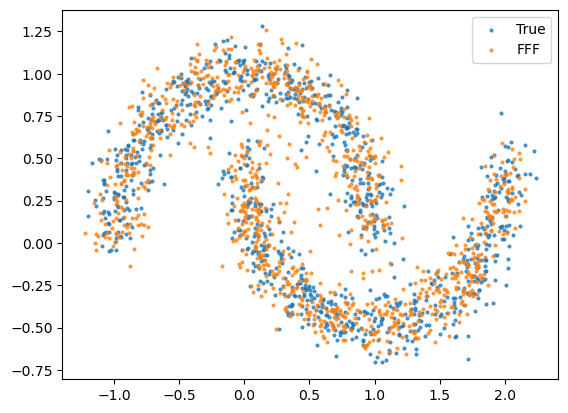

In [4]:
test_size = 1_000
test_batch, _ = make_moons(test_size, noise=noise)

plot_kwargs = dict(
    s=4,
    alpha=.7
)

plt.scatter(*test_batch.T, label="True", **plot_kwargs)

with torch.no_grad():
    plt.scatter(*sample(test_size).cpu().T, label="FFF", **plot_kwargs)
plt.legend()